In [164]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
# data directory
data_dir = Path("../data")

input_dir = data_dir / "input"
raw_dir = data_dir / "raw"
output_dir = data_dir / "processed"
sample_dir = data_dir / "samples"

rss_dir = raw_dir / "rss"
twitter_dir = raw_dir / "twitter"

## Load articles

In [166]:
articles = pd.read_csv(
    output_dir / "articles.csv",
    index_col="url_id",
    parse_dates=["published", "modified"],
)

In [167]:
orig_counts = articles.groupby("source").size()

## Postprocessing of collected articles

Articles are excluded if:

- they have been published before Mar 1 or after Apr 30 
- they are in Spanish
- they have been used in previous samples
- they were not successfully parsed by `newspaper`

### Publication date

Only keep articles published Mar 1 - Apr 30

In [168]:
# Remove timezone information
articles.published = articles.published.map(lambda x: x.replace(tzinfo=None))

good_articles = (articles.published>="01-03-2021")&(articles.published<="30-04-2021")
bad_articles = ~good_articles
print(f"Removing {bad_articles.sum()} articles in Spanish")

articles[bad_articles]["source"].value_counts()

Removing 1381 articles in Spanish


popsci       1328
ifls           51
wired           1
healthday       1
Name: source, dtype: int64

In [169]:
articles = articles[good_articles]

### Language

Remove articles that aren't English

In [170]:
spanish_articles = articles.section == "Consumer News in Spanish"
print(f"Removing {spanish_articles.sum()} articles in Spanish")

articles[spanish_articles]["source"].value_counts()

Removing 201 articles in Spanish


healthday    201
Name: source, dtype: int64

In [171]:
articles = articles[~spanish_articles]

### Intercoding samples

Remove articles that were used for previous samples

In [172]:
samples = sample_dir.glob("*.csv")

sampled_urls = []
for sample in samples:
    df = pd.read_csv(sample)
    if "link" in df:
        sampled_urls.extend(df["link"].tolist())
    else:
        sampled_urls.extend(df["url"].tolist())
        
sampled_articles = articles.url.isin(sampled_urls)
print(f"Removing {sampled_articles.sum()} articles previously sampled")
articles[sampled_articles]["source"].value_counts()

Removing 115 articles previously sampled


wired        20
nyt          19
medpage      17
guardian     17
healthday    17
newsmed      12
ifls          7
popsci        6
Name: source, dtype: int64

In [173]:
articles = articles[~sampled_articles]

### Successful content parsing

Remove articles that were not properly parsed by `newspaper`

In [174]:
df = articles[~articles.success]
errors = {
    "404 Client Error": df.error_msg.str.contains("404 Client Error").sum(),
    "402 Client Error": df.error_msg.str.contains("402 Client Error").sum(),
    "Timeout": df.error_msg.str.contains("Read timed out").sum(),
    "Wrong domain": df.error_msg.str.contains("wrong domain").sum(),
}

print(f"Removing {(~articles.success).sum()} that were not parsed successfully.")
print(f"Breakdown of reasons: {errors}")

articles[~articles.success].source.value_counts()

Removing 35 that were not parsed successfully.
Breakdown of reasons: {'404 Client Error': 14, '402 Client Error': 1, 'Timeout': 9, 'Wrong domain': 11}


newsmed    20
ifls       10
popsci      4
wired       1
Name: source, dtype: int64

In [175]:
articles = articles[articles.success]

## Final dataset

In [181]:
articles.shape

(5393, 12)

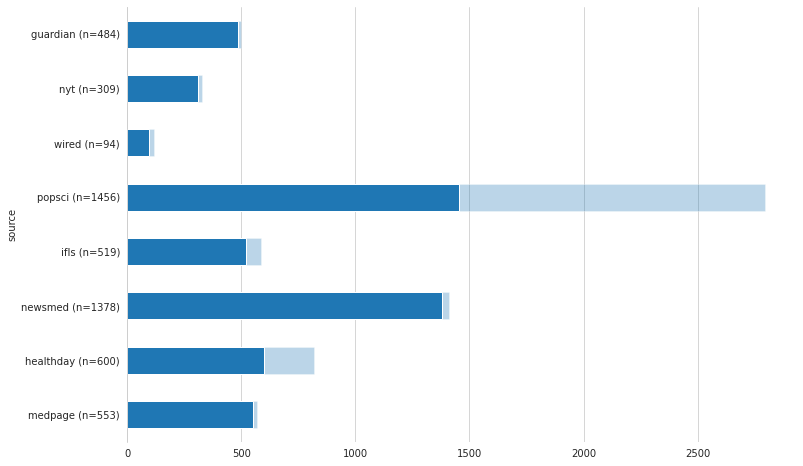

In [179]:
source_order = ["guardian", "nyt", "wired", "popsci", "ifls", "newsmed", "healthday", "medpage"]
source_order = source_order[::-1]

plt.figure(figsize=(12,8))
with sns.axes_style("whitegrid"):
    ax = orig_counts.loc[source_order].plot(kind="barh", alpha=.3)
    pdf = articles.groupby("source").size()
    pdf.loc[source_order].plot(kind="barh", ax=ax)
    sns.despine(bottom=True)
    plt.grid(False, axis="y")
#     xticks = range(100, 1600, 100)
    yticks, labels = plt.yticks()
    labels = [f"{_.get_text()} (n={pdf[_.get_text()]})" for _ in labels]
    plt.yticks(ticks=yticks, labels=labels)
#     plt.xticks(xticks, xticks)

In [178]:
articles.to_csv(output_dir / "filtered_articles.csv")